In [1]:
#!pip install pwlf
#!pip install gpyopt
#!pip install hampel
#!pip install seaborn
#!pip install sktime

In [2]:
#from pyspark import SparkContext
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
import scipy
import json
import pandas as pd
import datetime
from tqdm.notebook import trange, tqdm
from datetime import datetime
from dataclasses import make_dataclass

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from fnmatch import fnmatch
def getfiles(path, pattern=None):
    
    files_path = []
    if pattern != None:
        for path, subdirs, files in os.walk(path):
            for name in files:
                if fnmatch(name, pattern):
                    files_path.append(os.path.join(path, name))
    else:
        files_path = [f.path for f in os.scandir(path) if f.is_file()]
        
    return files_path

def getdirectories(path):
    return [f.path for f in os.scandir(path) if f.is_dir()]

In [5]:
from datetime import datetime
def remove_minutes(record):    
    newdatetime = datetime.fromisoformat(record)#.replace(minute=0, second=0, microsecond=0)
    return newdatetime

In [6]:
df_path = 'full_month_combined_pecking.csv'
#df_path = 'full_month_spectral_pecking.csv' 
pecking_data_frame = pd.read_csv(df_path)
print(pecking_data_frame["Pecking"].values.sum())
pecking_data_frame.head()

1519630


,Unnamed: 0,Time,Pecking,Others
0,0,2023-02-23 00:00:02,0,2385
1,1,2023-02-23 00:15:02,4,2390
2,2,2023-02-23 00:30:02,8,2339
3,3,2023-02-23 00:45:02,2,2357
4,4,2023-02-23 01:00:02,3,2434


In [7]:
pecking_data_frame['Date'] = pecking_data_frame["Time"].apply(lambda x: remove_minutes(x))
pecking_data_frame.set_index('Date')

,Unnamed: 0,Time,Pecking,Others
Date,,,,
2023-02-23 00:00:02,0,2023-02-23 00:00:02,0,2385
2023-02-23 00:15:02,1,2023-02-23 00:15:02,4,2390
2023-02-23 00:30:02,2,2023-02-23 00:30:02,8,2339
2023-02-23 00:45:02,3,2023-02-23 00:45:02,2,2357
2023-02-23 01:00:02,4,2023-02-23 01:00:02,3,2434
...,...,...,...,...
2023-03-13 22:45:02,1786,2023-03-13 22:45:02,1448,660
2023-03-13 23:00:02,1787,2023-03-13 23:00:02,1529,532
2023-03-13 23:15:02,1788,2023-03-13 23:15:02,1597,571


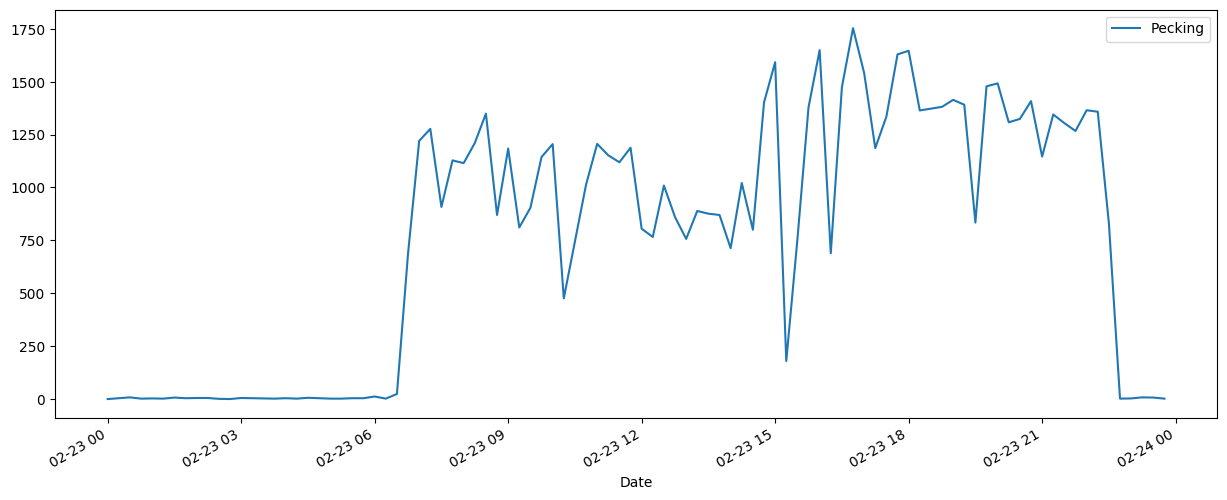

In [8]:
oneday_pecking = pecking_data_frame[pecking_data_frame['Date'].dt.strftime('%Y-%m-%d') == "2023-02-23"]
oneday_pecking.plot(x='Date', y=['Pecking'],use_index=True, figsize=(15,6))
plt.show()

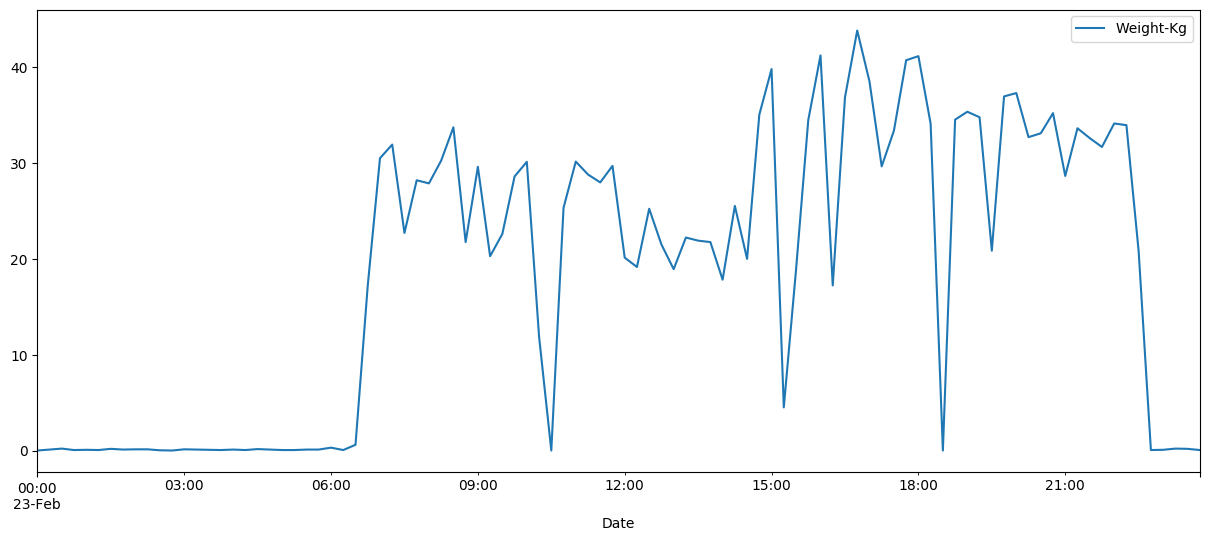

In [9]:
downsampled_pecking_data_frame = oneday_pecking[['Date', 'Pecking']].resample('15min', on='Date').sum() 
downsampled_pecking_data_frame["Weight-Kg"] = downsampled_pecking_data_frame['Pecking'] * 0.025 # to grams
downsampled_pecking_data_frame.plot(y=["Weight-Kg"],use_index=True, figsize=(15,6))
plt.show()

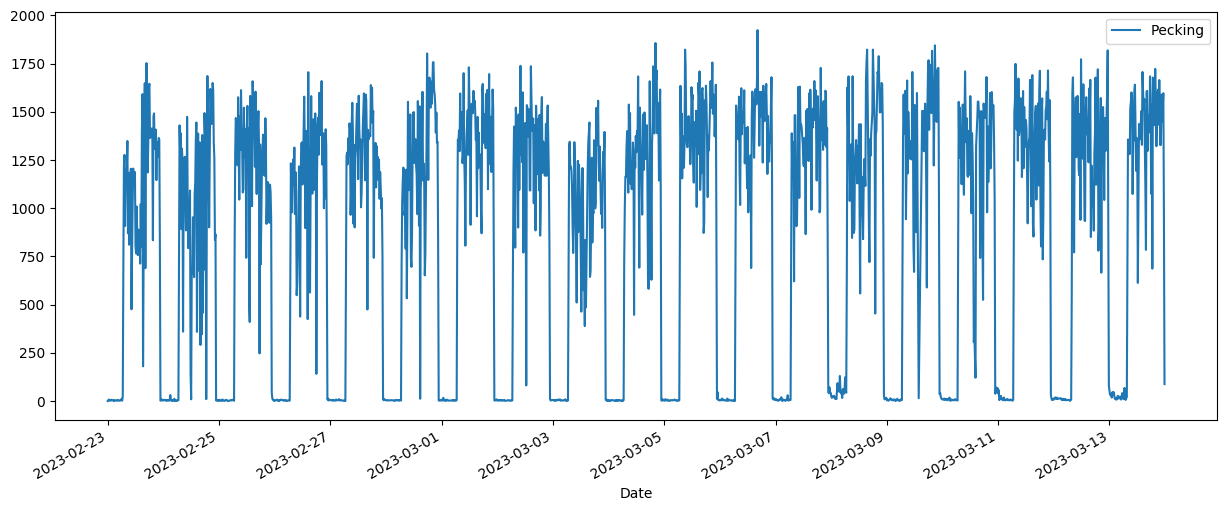

In [10]:
pecking_data_frame.plot(x='Date', y=['Pecking'],use_index=True, figsize=(15,6))
plt.show()

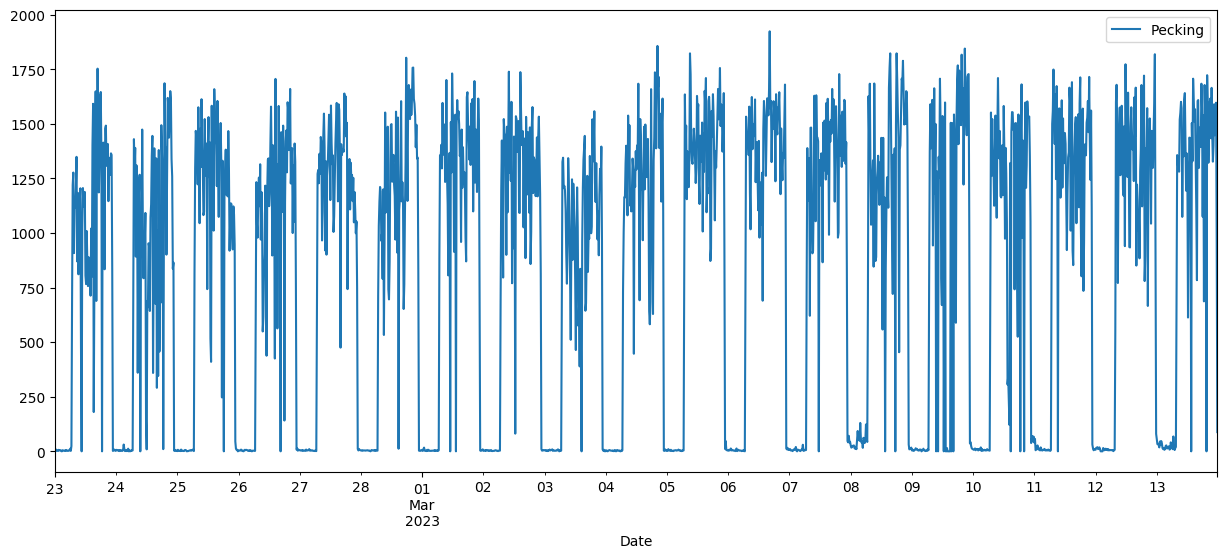

In [11]:
downsampled_pecking_data_frame = pecking_data_frame[['Date', 'Pecking']].resample('15min', on='Date').sum()
downsampled_pecking_data_frame.plot(y=['Pecking'],use_index=True, figsize=(15,6))
plt.show()

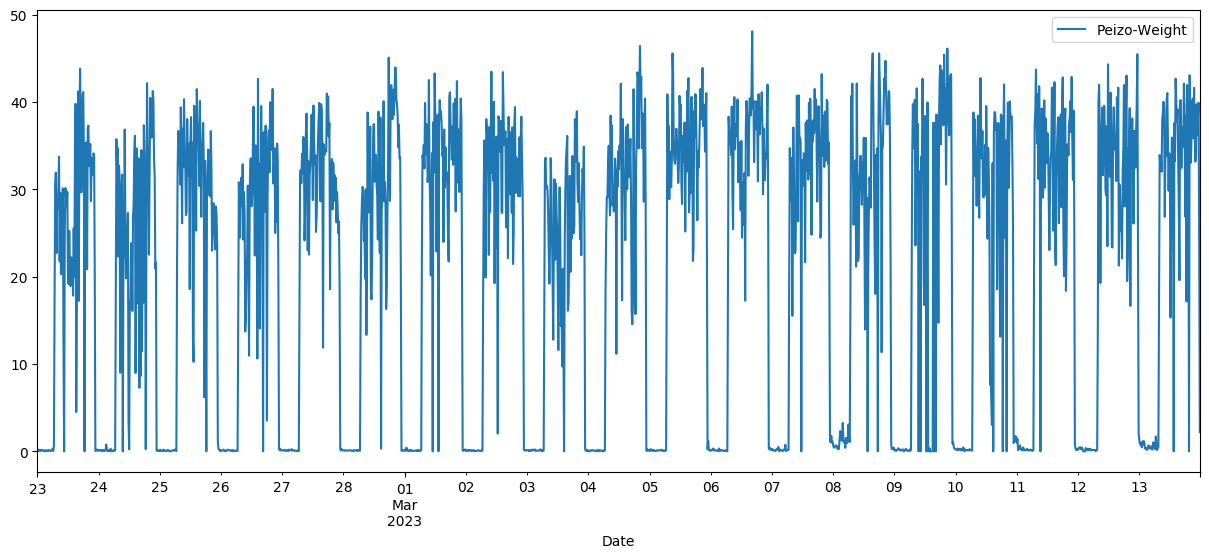

In [12]:
downsampled_pecking_data_frame["Peizo-Weight"] = downsampled_pecking_data_frame['Pecking'] * 0.025 # to grams
downsampled_pecking_data_frame.plot(y=["Peizo-Weight"],use_index=True, figsize=(15,6))
plt.show()

# Loading and preprocessing scale data

In [13]:
def extract_datetime(strdatetime):
    time_splited = strdatetime.split("_")
    time_stamp = datetime(year = int(time_splited[0]),
                          month = int(time_splited[1]),
                          day = int(time_splited[2]),
                          hour = int(time_splited[3]),
                          minute = int(time_splited[4]),
                          second = int(time_splited[5]))
    return time_stamp

In [14]:
root_path = './Dataset/'
raw_data_path = root_path + '/raw/'

In [15]:
from datetime import datetime
#loading filenames
times = []
weights = []
previous_weight = 0
for filepath in sorted(getfiles(raw_data_path, pattern="*.txt")):
    with open(filepath, 'r') as f:
        for line in f.readlines():
            time_wight_split = line.split(":") #split time stamp from weight
            time_stamp = time_wight_split[0].split(".")[0] # removing the milisecond number from the time stamp
            lb_removed = time_wight_split[1].replace(" lb","")
            sign = 1
            try:
#                 if "-" in lb_removed:
#                     lb_removed = lb_removed.replace("-","")
#                     sign = -1
                weight = sign * float(lb_removed.strip()) * 453.6 # to grams 
            except:
                continue
            time_stamp = extract_datetime(time_stamp)
            
            times.append(time_stamp)
            weights.append(weight)
            #do not add a new record if the weight value is not changed!
#             if previous_weight!=weight:
#                 times.append(time_stamp)
#                 weights.append(weight)
#                 previous_weight = weight



In [16]:
scale_df = pd.DataFrame(weights, columns = ["Weight"],index = times) 
scale_df['Date'] = times

In [17]:
# We missed the July 15th scale data. so we drop the records. 
scale_df = scale_df[scale_df['Date'].dt.strftime('%Y-%m-%d') != "2023-03-14"]
scale_df = scale_df[scale_df['Date'].dt.strftime('%Y-%m-%d') != "2023-03-15"]

In [18]:
from sktime.transformations.series.outlier_detection import HampelFilter

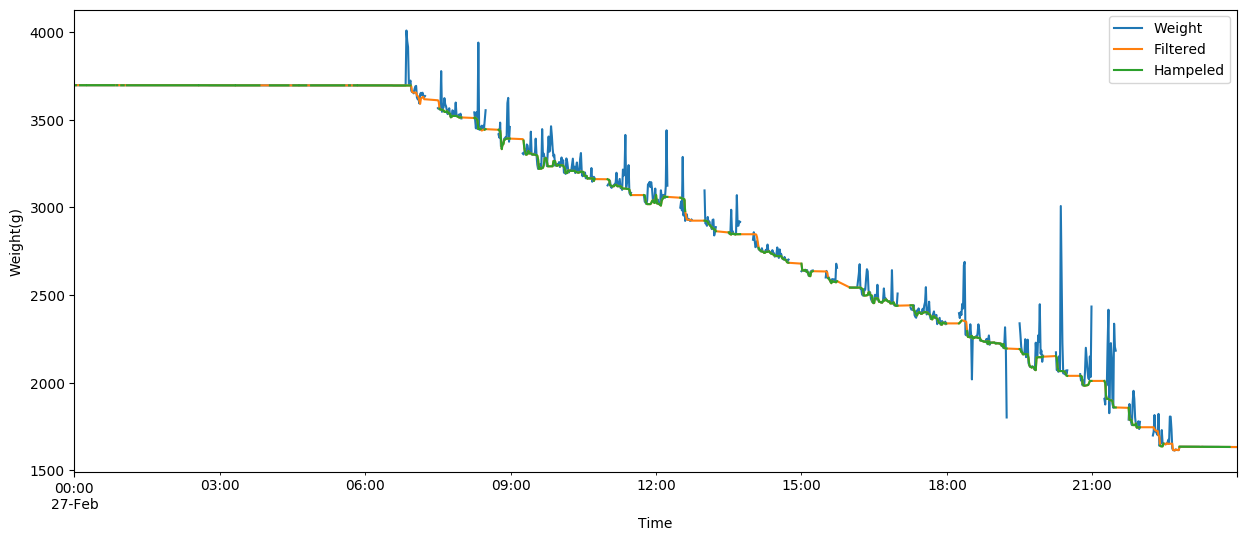

In [19]:
oneday_scale = scale_df[scale_df['Date'].dt.strftime('%Y-%m-%d') == "2023-02-27"]
oneday_scale['Filtered'] = oneday_scale['Weight'].rolling(15,min_periods=1).min().rolling(200,min_periods=1).median()

oneday_scale_downsampled = oneday_scale[['Weight','Filtered']].resample("1Min").median()

y = np.array(oneday_scale_downsampled['Filtered']) 
x = np.arange(y.shape[0])
transformer = HampelFilter(window_length=100,n_sigma=1)
y_hat = transformer.fit_transform(y)
oneday_scale_downsampled['Hampeled'] = y_hat

oneday_scale_downsampled['Filtered'] = oneday_scale_downsampled['Filtered'].interpolate()
ax = oneday_scale_downsampled.plot(y=['Weight','Filtered','Hampeled'],use_index=True, figsize=(15,6))
ax.set_xlabel("Time")
ax.set_ylabel("Weight(g)")
plt.show()

In [20]:
import pwlf
def fit_model(x, y, n_segments):
    model = pwlf.PiecewiseLinFit(x, y)
    res = model.fit(n_segments)
    return model

In [21]:
def get_24h_feed_consumption(model):
    
    oneday_consumption = []
    changing_points = []
    change_detected = False
    for i in range(96):
        y0=model.predict(i*15)
        y1=model.predict((i+1)*15)
        consumption = y0-y1
        consumption = consumption[0]
        
        if consumption<-500 and (not change_detected):
            changing_points.append(i)
            change_detected = True # To avoid multiple changepoint detection in one day!
            
        if consumption>-100 and consumption<0.0:
            oneday_consumption.append(0)
            
        elif consumption<-100:
            oneday_consumption.append(float('nan'))
        
        elif consumption>100: # get rid of noise and invalid data 
            oneday_consumption.append(float('nan'))
            
        else:
            oneday_consumption.append(consumption)
    return np.array(oneday_consumption), changing_points

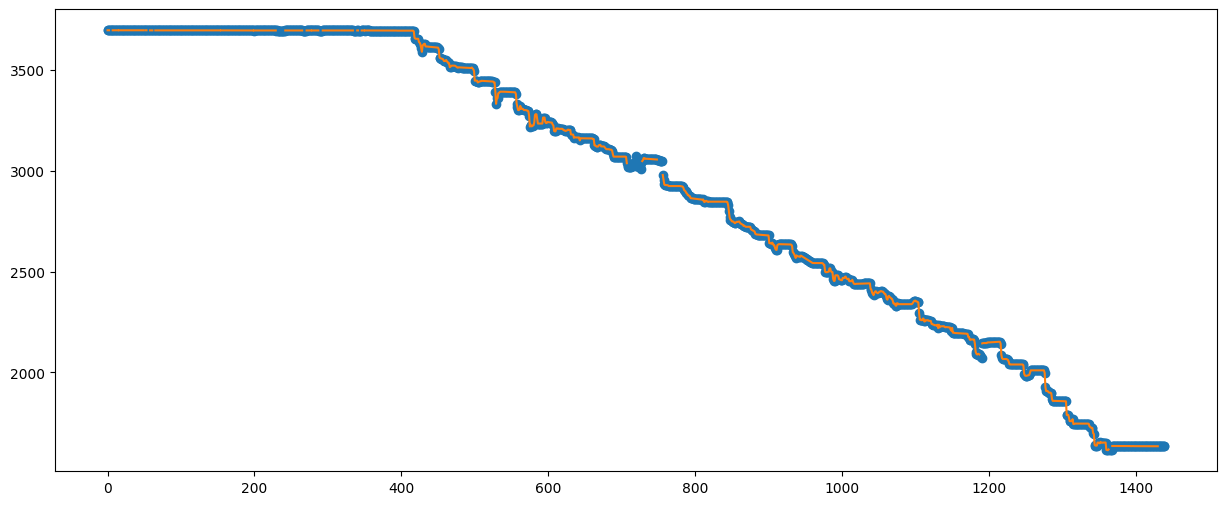

In [22]:


y = np.array(oneday_scale_downsampled['Filtered']) 
x = np.arange(y.shape[0])
transformer = HampelFilter(window_length=100,n_sigma=1)
y_hat = transformer.fit_transform(y)

# predict for the determined points
xHat = np.linspace(min(x), max(x), num=y.shape[0])
 

# plot the results
plt.figure(figsize=(15,6))
plt.plot(x, y, 'o')
plt.plot(xHat, y_hat, '-')
plt.show()

original shape: (6271241, 2) downsamped shape: (27360, 2)


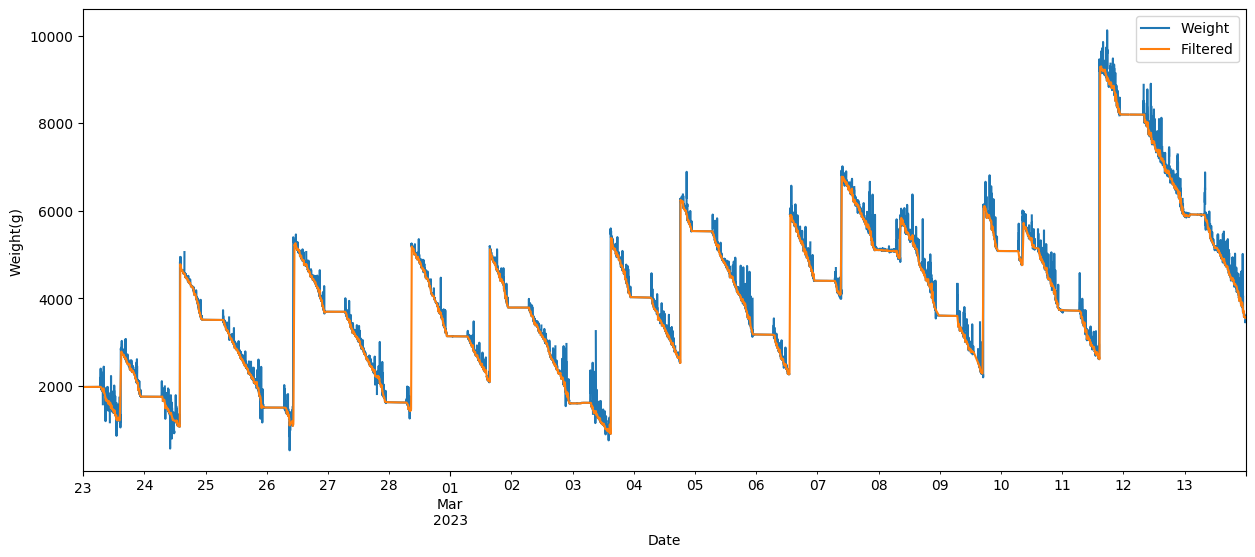

In [23]:
downsampled_dataset = scale_df[['Weight',]].resample("1Min").mean()

y= np.array(downsampled_dataset['Weight']) 
transformer = HampelFilter(window_length=100,n_sigma=1)
y_hat = transformer.fit_transform(y)
downsampled_dataset['Filtered'] = y_hat
downsampled_dataset['Filtered'] = downsampled_dataset['Filtered'].interpolate()

downsampled_dataset['Filtered'] = downsampled_dataset['Filtered'].rolling(10,min_periods=1).min()

ax = downsampled_dataset.plot(y=['Weight','Filtered'],use_index=True, figsize=(15,6))
ax.set_xlabel("Date")
ax.set_ylabel("Weight(g)")
print("original shape:",scale_df.shape,"downsamped shape:",downsampled_dataset.shape)

 
plt.show()

In [24]:
from tqdm.notebook import trange, tqdm
calcs = []
import datetime
day = datetime.datetime(2023, 2, 23, 0, 0, 0)
total_change_points = [] 
for i in trange(19):
    oneday_scale = downsampled_dataset.loc[day.strftime("%Y-%m-%d")]
    y = np.array(oneday_scale['Filtered']) 
    x = np.arange(y.shape[0])
     
    model = fit_model(x,y,9)
    day_consumption, change_points = get_24h_feed_consumption(model)
    for point in change_points:
        total_change_points.append(day+datetime.timedelta(minutes=point*15))
    calcs.append(day_consumption) 
    day = day + datetime.timedelta(days=1)

  0%|          | 0/19 [00:00<?, ?it/s]

original shape: (6271241, 2) downsamped shape: (27360, 2)


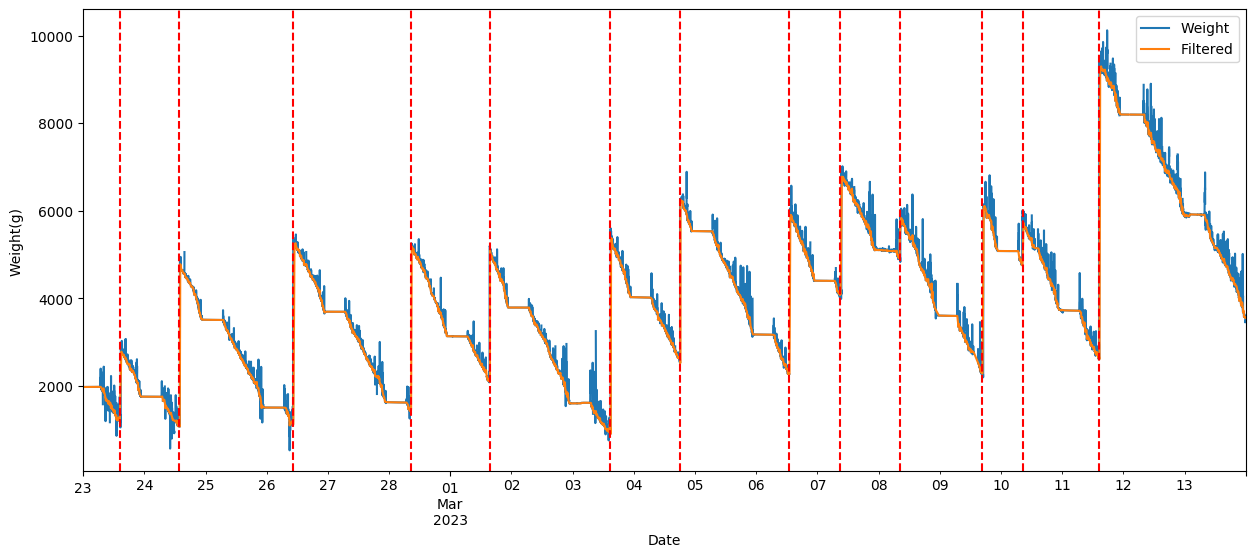

In [25]:
ax = downsampled_dataset.plot(y=['Weight','Filtered'],use_index=True, figsize=(15,6))
ax.set_xlabel("Date")
ax.set_ylabel("Weight(g)")
print("original shape:",scale_df.shape,"downsamped shape:",downsampled_dataset.shape)

for point in total_change_points:
    ax.axvline(point, color="red", linestyle="--")

plt.show()

In [26]:
first_day = datetime.datetime(2023, 2, 23, 0, 0, 0)
last_day = datetime.datetime(2023, 3, 13, 0, 0, 0)
filtered = downsampled_pecking_data_frame.loc[first_day.strftime("%Y-%m-%d"):last_day.strftime("%Y-%m-%d")]
filtered["Scale-Weight"] = np.array(calcs).ravel()
filtered['Scale-Weight'] = filtered['Scale-Weight'].interpolate()
filtered_downsampled = filtered[['Scale-Weight','Peizo-Weight']].resample("60Min").sum()

## Model Evaluation

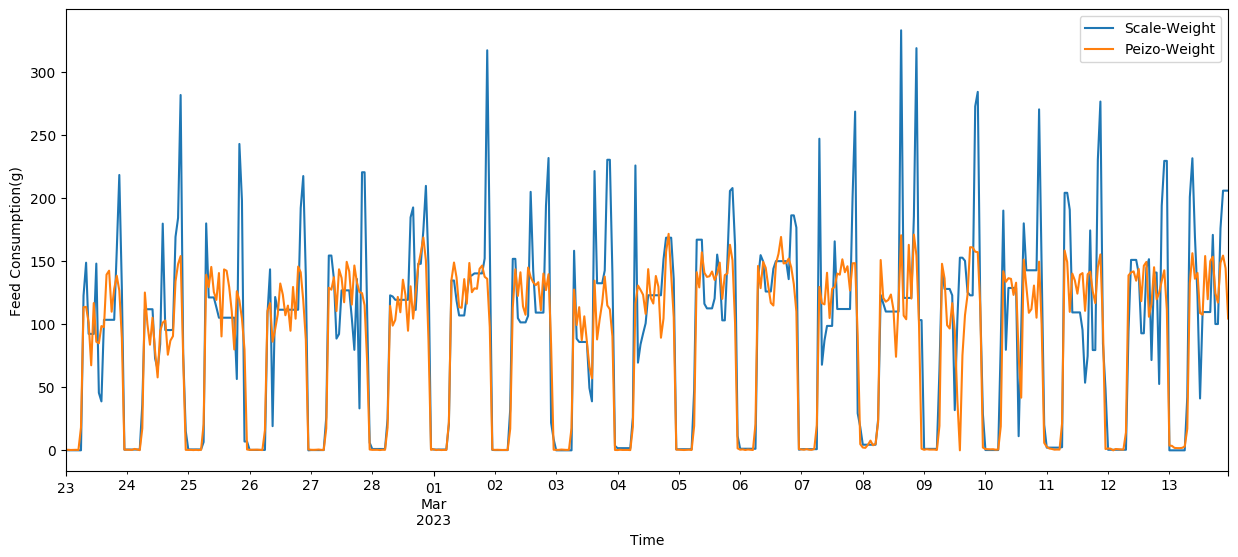

In [27]:
ax = filtered_downsampled.plot(y=['Scale-Weight','Peizo-Weight'],use_index=True, figsize=(15,6))
ax.set_xlabel("Time")
ax.set_ylabel("Feed Consumption(g)")

# for point in total_change_points:
#     ax.axvline(point, color="red", linestyle="--")

plt.show()

In [28]:
filtered_downsampled.corr()

,Scale-Weight,Peizo-Weight
Scale-Weight,1.000000,0.852981
Peizo-Weight,0.852981,1.000000


In [29]:
from sklearn.metrics import r2_score,mean_absolute_error,explained_variance_score
r2_score(filtered_downsampled['Scale-Weight'], filtered_downsampled['Peizo-Weight'])

0.7153424829747972

### Each Hour Analysis

In [31]:
import datetime
from dataclasses import make_dataclass

columns_list = []
columns_list.append(("Date", datetime))

for hour in range(24):
    h = 'h'+str(hour)
    columns_list.append((h, int))

hourly_r2_data = make_dataclass("Daily", columns_list)

In [32]:
day = datetime.datetime(2023, 2, 23, 0, 0, 0)
hourly_result = []
daily_result = []
for i in trange(19):
    
    day_copy = day
    hours =[]
    errors=[]

    for hour in range(24):
        h = 'h'+str(hour)
        one_hour = filtered.loc[day_copy.strftime("%Y-%m-%d %H")]
        
        one_hour_error = mean_absolute_error(one_hour['Scale-Weight'], one_hour['Peizo-Weight'])
 
        errors.append(one_hour_error)
        hours.append(h)
        
        day_copy = day_copy + datetime.timedelta(hours=1)
        
    packed_results = dict(zip(hours,errors))
    hourly_result.append(hourly_r2_data(day, **packed_results))
    day = day + datetime.timedelta(days=1)

hourly_result_df = pd.DataFrame(hourly_result)
hourly_result_df.describe()

  0%|          | 0/19 [00:00<?, ?it/s]

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.216764,0.191257,0.182722,0.202157,0.151321,0.167174,4.432559,10.145886,9.347568,8.789833,...,11.339043,11.652466,10.409665,10.290671,9.378129,9.427761,17.413896,25.758283,16.455502,6.235459
std,0.234045,0.212938,0.168231,0.186935,0.122166,0.134500,3.899423,8.021668,5.761739,5.234178,...,8.776705,8.955908,6.272381,5.284183,5.363989,5.097559,8.420380,9.384336,4.118528,9.592517
min,0.015195,0.043449,0.031163,0.031337,0.031250,0.018750,0.025991,0.775000,2.148890,2.976308,...,1.709235,1.997533,2.530629,1.987500,1.722559,2.163511,1.787500,7.316678,7.556954,0.062500
25%,0.079546,0.090343,0.069188,0.100993,0.072009,0.068792,1.826778,6.248567,4.956386,5.717651,...,5.388947,6.327483,6.049793,7.395284,5.487551,6.546024,10.920861,22.318457,14.167131,0.207942
50%,0.123706,0.113285,0.135627,0.143290,0.094741,0.116783,3.922305,7.678549,7.043750,7.150267,...,10.052918,8.418750,10.066182,9.727118,10.035293,8.811227,17.937027,26.323003,16.652119,2.069869
75%,0.221434,0.188419,0.198935,0.222298,0.173935,0.231521,5.066640,12.013944,13.306371,9.931250,...,14.140732,13.941399,11.882549,11.368634,10.810514,10.507463,24.506752,30.212759,18.203901,5.191061
max,0.950000,0.881250,0.700000,0.816184,0.431250,0.487500,16.470012,33.243710,20.880146,21.055679,...,38.139083,40.576609,27.590316,24.872417,26.386897,23.022407,30.984358,45.254885,25.354930,29.430547


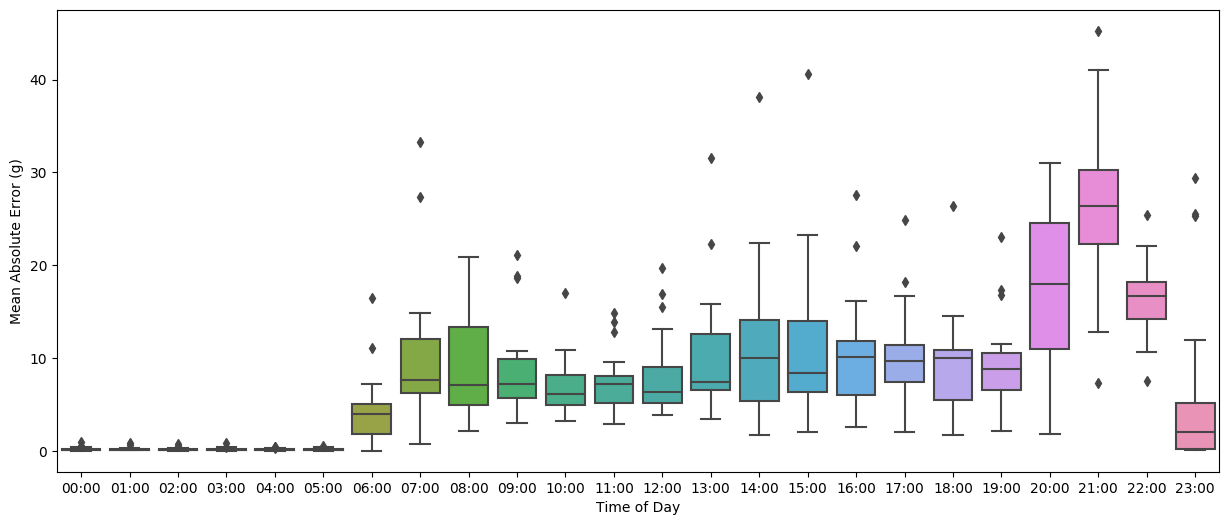

In [33]:
import seaborn as sns
tickes = []
for hour in range(24):
    tickes.append(f"{str(hour).zfill(2)}:00")    
plt.figure(figsize=(15,6))
b0xplot = sns.boxplot(data=hourly_result_df)
b0xplot.set(xlabel='Time of Day', ylabel='Mean Absolute Error (g)')
b0xplot.set_xticklabels(tickes)
plt.show()

In [34]:
day_resolution = filtered.resample("1D").sum()
day_resolution.describe()

,Pecking,Peizo-Weight,Scale-Weight
count,19.000000,19.000000,19.000000
mean,79980.526316,1999.513158,2183.687004
std,7407.766708,185.194168,194.612066
min,65261.000000,1631.525000,1801.887198
25%,75375.000000,1884.375000,2049.762397
50%,81630.000000,2040.750000,2229.362074
75%,85115.500000,2127.887500,2344.520878
max,90458.000000,2261.450000,2475.402324


In [35]:
day_resolution.corr()

,Pecking,Peizo-Weight,Scale-Weight
Pecking,1.000000,1.000000,0.590321
Peizo-Weight,1.000000,1.000000,0.590321
Scale-Weight,0.590321,0.590321,1.000000


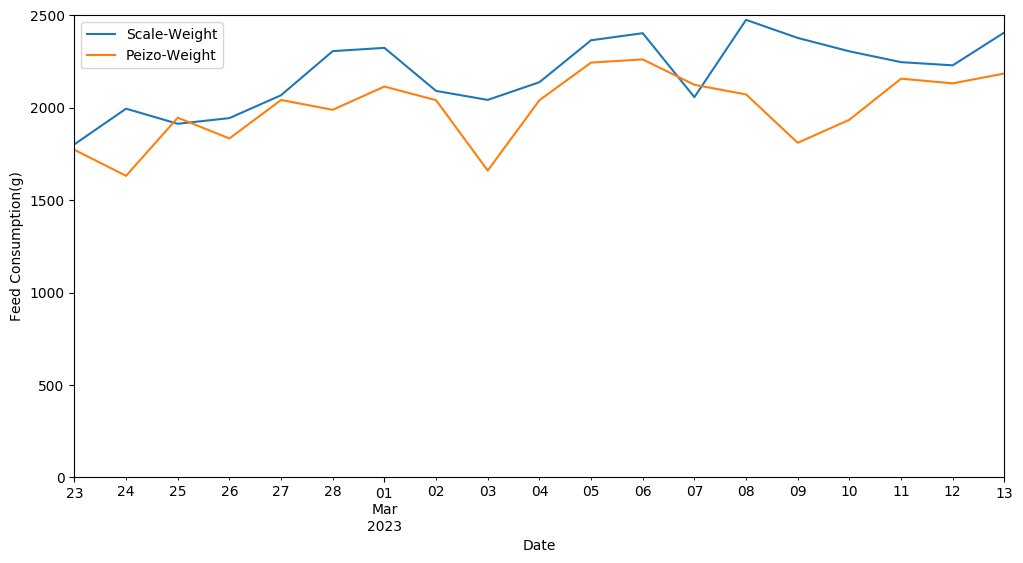

In [36]:
ax = day_resolution.plot(y=['Scale-Weight','Peizo-Weight'],use_index=True, figsize=(12,6))
ax.set_ylim(0,2500)
ax.set_xlabel("Date")
ax.set_ylabel("Feed Consumption(g)")
plt.show()

In [37]:
day_resolution['Error'] = abs(day_resolution['Scale-Weight'] - day_resolution['Peizo-Weight'])

In [40]:
day_resolution['ErrorPercentage'] = (day_resolution['Error'] / day_resolution['Scale-Weight']) * 100
day_resolution['Accuracy'] = 100 - (day_resolution['Error'] / day_resolution['Scale-Weight']) * 100
day_resolution = day_resolution.round(1)
day_resolution.head(19)

,Pecking,Peizo-Weight,Scale-Weight,Error,Accuracy,ErrorPercentage
Date,,,,,,
2023-02-23,70895,1772.4,1801.9,29.5,98.4,1.6
2023-02-24,65261,1631.5,1994.8,363.3,81.8,18.2
2023-02-25,77839,1946.0,1913.2,32.8,98.3,1.7
2023-02-26,73349,1833.7,1943.7,110.0,94.3,5.7
2023-02-27,81668,2041.7,2067.7,26.0,98.7,1.3
2023-02-28,79549,1988.7,2306.2,317.5,86.2,13.8
2023-03-01,84582,2114.6,2324.0,209.4,91.0,9.0
2023-03-02,81630,2040.8,2091.0,50.2,97.6,2.4
2023-03-03,66396,1659.9,2042.3,382.4,81.3,18.7


In [ ]:
day_resolution.to_csv("test.cs")

In [43]:
results = day_resolution.describe()
results = results.round(1)
results.head(10)

,Pecking,Peizo-Weight,Scale-Weight,Error,Accuracy,ErrorPercentage
count,19.0,19.0,19.0,19.0,19.0,19.0
mean,79980.5,1999.5,2183.7,194.6,91.3,8.7
std,7407.8,185.2,194.6,159.5,7.0,7.0
min,65261.0,1631.5,1801.9,26.0,76.1,1.3
25%,75375.0,1884.4,2049.8,78.1,85.1,3.6
50%,81630.0,2040.8,2229.4,120.8,94.3,5.7
75%,85115.5,2127.9,2344.5,340.4,96.4,15.0
max,90458.0,2261.5,2475.4,567.6,98.7,23.9
